In [ ]:
!unzip /content/temp.zip

In [ ]:
!rm -rf /content/temp/.DS_Store  

In [ ]:
import math


class QuerySearch:
    """ Searches similarity of query image vector with extracted vectors from database"""

    def __init__(self, queryFeature, features):

        self.features = features
        self.queryFeature = queryFeature

    def __cosine_similarity(self, queryVector, vector):
        # Computes cosine similarity between two vectors

        eps = 1e-10
        dot_product = sum(q*v for q, v in zip(queryVector, vector))

        queryMagnitude = math.sqrt(sum([val**2 for val in queryVector]))
        vectorMagnitude = math.sqrt(sum([val**2 for val in vector]))
        magnitude = (queryMagnitude*vectorMagnitude)+eps

        if not magnitude:
            return 0

        cosine_similarity = round(dot_product/magnitude, 5)
        return cosine_similarity

    def __chi2_distance(self, queryVector, vector):
        # Computes chi-square distance between two vectors

        eps = 1e-10
        dists = [((q - v) ** 2) / (q + v + eps)
                 for (q, v) in zip(queryVector, vector)]
        chi2_distance = 0.5 * sum(dists)
        chi2_distance = np.sum(chi2_distance)
        print(chi2_distance)
        #chi2_distance = round(chi2_distance, 5)
        return chi2_distance

    def __SAD_distance(self, queryVector, vector):
        # Computes SAD distance between two vectors

        dists = [abs(q-v) for (q, v) in zip(queryVector, vector)]
        SAD_distance = sum(dists)
        return SAD_distance
        
    def euclidean_distance(self, queryVector, vector):

        dists = [sqrt(sum(pow(a-b,2) for a,b in zip(queryVector, vector)))]
        return dists

    def nth_root(value, n_root):

        root_value = 1/float(n_root)
        return round(Decimal(value) ** Decimal(root_value),3)

    def Minkowski_distance(self, queryVector, vector, p_value):

        return nth_root(sum(pow(abs(a-b),p_value) for a,b in zip(queryVector, vector)), p_value)

    def jaccard_similarity(self, queryVector, vector):

          intersection_cardinality = len(set.intersection(*[set(queryVector), set(vector)]))
          union_cardinality = len(Set.union(*[set(queryVector), set(vector)]))

          return intersection_cardinality/float(union_cardinality)

    def performSearch(self):
        # Return similarity indices of queryVector and databse images

        searchSimilarityScores = []

        for image in self.features:
            queryVector = self.queryFeature
            vector = self.features[image]
            cosine_similarity = self.__chi2_distance(queryVector, vector)

            searchSimilarityScores.append((image, cosine_similarity))

        return searchSimilarityScores

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers 
from keras.layers import GlobalMaxPooling2D
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
# from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications import MobileNet
from keras.applications import DenseNet121
from keras.models import Model
from tensorflow.keras.applications import EfficientNetB0


def FeatureVectors(image):
  # base_model=VGG16(include_top=False, weights='imagenet',input_shape=(128,128,3))
  # model = InceptionV3(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
  model = MobileNet(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
  # model = DenseNet121(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
  #model = ResNet50(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
  # model = EfficientNetB0(weights='imagenet', include_top=False, input_shape = (224, 224, 3))
  model.trainable = False
  output = GlobalMaxPooling2D()(model.outputs)
  model = Model(inputs=model.inputs, outputs=output)
  featuresTrain= model.predict(image)

  #reshape to flatten feature for Train data
  featuresTrain= featuresTrain.reshape(featuresTrain.shape[0], -1)
  
  return featuresTrain

In [ ]:
import os
import sys
import threading
import concurrent.futures
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
# from FeatureVectors import FeatureVectors
# from QuerySearch import QuerySearch


def extractFeatureVectors(image_path):
    # Extracts feature vectors for input image

    image = cv2.imread(image_path)
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, 0) 
    vectors = FeatureVectors(image)
    #vectors = featureVectors.getFeatureVector()
    imageName = image_path.split("/")[-1]
    return [imageName, vectors]


def ThreadedFeatureExtraction(images_list):
     # Performing feature extraction of databse images using multithreading

    features = {}
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = [executor.submit(extractFeatureVectors, image_path)
                   for image_path in images_list]

    for f in concurrent.futures.as_completed(results):
        imageName, vectors = f.result()
        features[imageName] = vectors

    return features


def getImg(img):
    image_db_path = "Image_Database/"
    image = cv2.imread(image_db_path+img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def ImageSearch(queryImage):
    # Performs Image Search using Query image

    # image_db_path = "/content/temp/"
    # image_paths = []
    # for img in os.listdir(image_db_path):
    #     image_paths.append(image_db_path+img)

    # features = ThreadedFeatureExtraction(image_paths)
    # print(len(features))
    # queryImage_path = image_db_path+queryImage
    # imageName, queryVector = extractFeatureVectors(queryImage_path)

    imageName, queryVector = extractFeatureVectors(queryImage)
    print(imageName)

    image_db_path = "/content/temp/"
    image_paths = []
    for img in os.listdir(image_db_path):
        #print(img)
        image_paths.append(image_db_path+img)

    features = ThreadedFeatureExtraction(image_paths)
    print(len(features))

    search = QuerySearch(queryVector, features)

    results = search.performSearch()
    results.sort(key=lambda res: res[1])

    return results


In [ ]:
start = time.perf_counter()
search_results = ImageSearch("/content/alibaba_1345.jpg")
end = time.perf_counter()
print(f"Parallel Time : {end-start}")
prl_time = end-start

In [ ]:
for sr in search_results[:5]:
    print(sr)

('alibaba_1345.jpg', 0.0)
('213_0093.jpg', 2113.8057)
('alibaba_1396.jpg', 2136.899)
('alibaba_1370.jpg', 2225.0747)
('213_0008.jpg', 2235.4436)


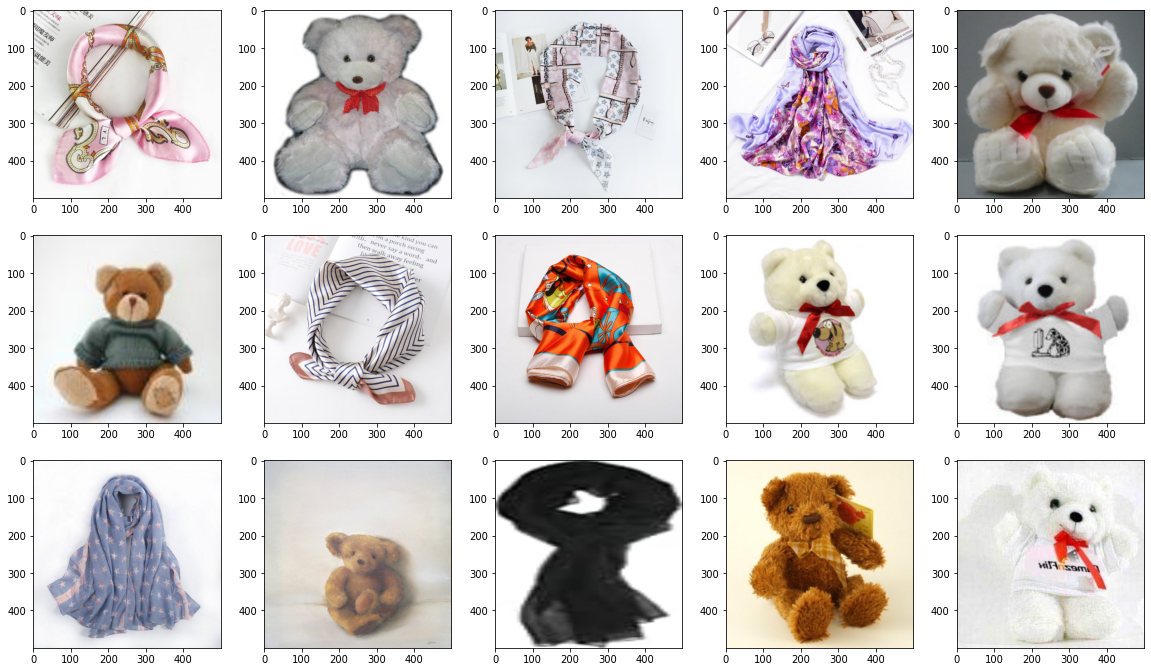

In [ ]:
def getImg(img):
    image_db_path = "/content/temp/"
    image = cv2.imread(image_db_path+img)
    image = cv2.resize(image, (500,500))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    print(img)

plt.figure(figsize=(20,20)) 

for i in range(15):
    plt.subplot(5,5,i+1)
    plt.imshow(getImg(search_results[i][0]))

plt.show()

In [ ]:
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np


def extractFeatureVectors(image_path):
    # Extracts feature vectors for input image

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.expand_dims(image, 0)
    vectors = FeatureVectors(image)
    # vectors = featureVectors.getFeatureVector()

    imageName = image_path.split("/")[-1]
    return [imageName, vectors]


def ImageSearchserial(queryImage):
    # Performs Image Search using Query image

    image_db_path = "/content/temp/"
    image_paths = []
    for img in os.listdir(image_db_path):
        image_paths.append(image_db_path+img)

    features = {}
    for image in image_paths:
        print(image)
        imageName, vector = extractFeatureVectors(image)
        print(vector[0])
        features[imageName] = vector

    queryImage_path = image_db_path+queryImage

    imageName, queryVector = extractFeatureVectors(queryImage)

    search = QuerySearch(queryVector, features)

    results = search.performSearch()
    results.sort(key=lambda res: res[1])

    return results

In [ ]:
start = time.perf_counter()
search_results = ImageSearchserial("/content/alibaba_1345.jpg")
end = time.perf_counter()
print(f"Sequential Time : {end-start}")
seq_time = end-start

In [ ]:
for sr in search_results[:5]:
    print(sr)

('P_0_ (53).jpg', -2609.631)
('P_0_ (64).jpg', -15.360062)
('P_0_ (56).jpg', 2110.1394)
('P_0_ (72).jpg', 2116.1504)
('P_0_ (74).jpg', 2631.0198)


In [ ]:
def getImg(img):
    image_db_path = "/content/temp/"
    image = cv2.imread(image_db_path+img)
    image = cv2.resize(image, (500,500))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

plt.figure(figsize=(20,20)) 

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(getImg(search_results[i][0]))

plt.show()